In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a Convolutional Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

# Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Add skip connection if input and output channels differ
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

# Define an Upsampling Block
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return x

# Define the ResUNet Model
class ResUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(ResUNet, self).__init__()
        
        # Encoder
        self.enc1 = ConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ResidualBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ResidualBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bridge
        self.bridge = ConvBlock(512, 1024)
        
        # Decoder
        self.dec4 = UpConv(1024, 512)
        self.dec4_conv = ResidualBlock(1024, 512)
        self.dec3 = UpConv(512, 256)
        self.dec3_conv = ConvBlock(512, 256)
        self.dec2 = UpConv(256, 128)
        self.dec2_conv = ResidualBlock(256, 128)
        self.dec1 = UpConv(128, 64)
        self.dec1_conv = ConvBlock(128, 64)
        
        # Output
        self.final = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        
        # Bridge
        bridge = self.bridge(self.pool4(enc4))
        
        # Decoder
        dec4 = self.dec4(bridge, enc4)
        dec4 = self.dec4_conv(dec4)
        dec3 = self.dec3(dec4, enc3)
        dec3 = self.dec3_conv(dec3)
        dec2 = self.dec2(dec3, enc2)
        dec2 = self.dec2_conv(dec2)
        dec1 = self.dec1(dec2, enc1)
        dec1 = self.dec1_conv(dec1)
        
        # Output
        return self.final(dec1)


Using device: cuda
Loading data...


100%|██████████| 110/110 [00:03<00:00, 33.95it/s]


Train: 2751, Validation: 589, Test: 589


Epoch 1/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.75it/s]


Epoch 1/100 - Train Loss: 0.6341, Train Dice: 0.9599, Val Loss: 0.5934, Val Dice: 0.9468
Saved best model with validation loss: 0.5934


Epoch 2/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.72it/s]


Epoch 2/100 - Train Loss: 0.5692, Train Dice: 0.9386, Val Loss: 0.5467, Val Dice: 0.9122
Saved best model with validation loss: 0.5467


Epoch 3/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.61it/s]


Epoch 3/100 - Train Loss: 0.5197, Train Dice: 0.8960, Val Loss: 0.5024, Val Dice: 0.8911
Saved best model with validation loss: 0.5024


Epoch 4/100 (Validation): 100%|██████████| 74/74 [00:05<00:00, 14.54it/s]


Epoch 4/100 - Train Loss: 0.4784, Train Dice: 0.8519, Val Loss: 0.4633, Val Dice: 0.8287
Saved best model with validation loss: 0.4633


Epoch 5/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 14.95it/s]


Epoch 5/100 - Train Loss: 0.4311, Train Dice: 0.7881, Val Loss: 0.4118, Val Dice: 0.7681
Saved best model with validation loss: 0.4118


Epoch 6/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.02it/s]


Epoch 6/100 - Train Loss: 0.3799, Train Dice: 0.7071, Val Loss: 0.3957, Val Dice: 0.7515
Saved best model with validation loss: 0.3957


Epoch 7/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.51it/s]


Epoch 7/100 - Train Loss: 0.3271, Train Dice: 0.6151, Val Loss: 0.3330, Val Dice: 0.6262
Saved best model with validation loss: 0.3330


Epoch 8/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.64it/s]


Epoch 8/100 - Train Loss: 0.2697, Train Dice: 0.5100, Val Loss: 0.2603, Val Dice: 0.4931
Saved best model with validation loss: 0.2603


Epoch 9/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.63it/s]


Epoch 9/100 - Train Loss: 0.2279, Train Dice: 0.4306, Val Loss: 0.2674, Val Dice: 0.5105
EarlyStopping counter: 1 out of 10


Epoch 10/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.62it/s]


Epoch 10/100 - Train Loss: 0.1908, Train Dice: 0.3598, Val Loss: 0.2166, Val Dice: 0.4076
Saved best model with validation loss: 0.2166


Epoch 11/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.65it/s]


Epoch 11/100 - Train Loss: 0.1637, Train Dice: 0.3080, Val Loss: 0.1836, Val Dice: 0.3490
Saved best model with validation loss: 0.1836


Epoch 12/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.68it/s]


Epoch 12/100 - Train Loss: 0.1499, Train Dice: 0.2803, Val Loss: 0.2560, Val Dice: 0.4831
EarlyStopping counter: 1 out of 10


Epoch 13/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.70it/s]


Epoch 13/100 - Train Loss: 0.1399, Train Dice: 0.2602, Val Loss: 0.1869, Val Dice: 0.3514
EarlyStopping counter: 2 out of 10


Epoch 14/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.68it/s]


Epoch 14/100 - Train Loss: 0.1338, Train Dice: 0.2486, Val Loss: 0.1552, Val Dice: 0.2926
Saved best model with validation loss: 0.1552


Epoch 15/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.64it/s]


Epoch 15/100 - Train Loss: 0.1211, Train Dice: 0.2244, Val Loss: 0.1336, Val Dice: 0.2523
Saved best model with validation loss: 0.1336


Epoch 16/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.70it/s]


Epoch 16/100 - Train Loss: 0.1044, Train Dice: 0.1932, Val Loss: 0.1463, Val Dice: 0.2742
EarlyStopping counter: 1 out of 10


Epoch 17/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.68it/s]


Epoch 17/100 - Train Loss: 0.1105, Train Dice: 0.2040, Val Loss: 0.1414, Val Dice: 0.2642
EarlyStopping counter: 2 out of 10


Epoch 18/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.67it/s]


Epoch 18/100 - Train Loss: 0.1067, Train Dice: 0.1971, Val Loss: 0.1297, Val Dice: 0.2423
Saved best model with validation loss: 0.1297


Epoch 19/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.67it/s]


Epoch 19/100 - Train Loss: 0.0926, Train Dice: 0.1708, Val Loss: 0.1327, Val Dice: 0.2481
EarlyStopping counter: 1 out of 10


Epoch 20/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.68it/s]


Epoch 20/100 - Train Loss: 0.0901, Train Dice: 0.1662, Val Loss: 0.1233, Val Dice: 0.2314
Saved best model with validation loss: 0.1233


Epoch 21/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.74it/s]


Epoch 21/100 - Train Loss: 0.0825, Train Dice: 0.1518, Val Loss: 0.1214, Val Dice: 0.2276
Saved best model with validation loss: 0.1214


Epoch 22/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.75it/s]


Epoch 22/100 - Train Loss: 0.0796, Train Dice: 0.1458, Val Loss: 0.1229, Val Dice: 0.2292
EarlyStopping counter: 1 out of 10


Epoch 23/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.69it/s]


Epoch 23/100 - Train Loss: 0.0766, Train Dice: 0.1406, Val Loss: 0.1241, Val Dice: 0.2295
EarlyStopping counter: 2 out of 10


Epoch 24/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.69it/s]


Epoch 24/100 - Train Loss: 0.0874, Train Dice: 0.1612, Val Loss: 0.1218, Val Dice: 0.2273
EarlyStopping counter: 3 out of 10


Epoch 25/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.70it/s]


Epoch 25/100 - Train Loss: 0.0741, Train Dice: 0.1358, Val Loss: 0.1139, Val Dice: 0.2140
Saved best model with validation loss: 0.1139


Epoch 26/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.69it/s]


Epoch 26/100 - Train Loss: 0.0920, Train Dice: 0.1681, Val Loss: 0.1423, Val Dice: 0.2632
EarlyStopping counter: 1 out of 10


Epoch 27/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.48it/s]


Epoch 27/100 - Train Loss: 0.0848, Train Dice: 0.1556, Val Loss: 0.1101, Val Dice: 0.2037
Saved best model with validation loss: 0.1101


Epoch 28/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.68it/s]


Epoch 28/100 - Train Loss: 0.0714, Train Dice: 0.1306, Val Loss: 0.1133, Val Dice: 0.2107
EarlyStopping counter: 1 out of 10


Epoch 29/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.70it/s]


Epoch 29/100 - Train Loss: 0.0682, Train Dice: 0.1250, Val Loss: 0.1941, Val Dice: 0.3618
EarlyStopping counter: 2 out of 10


Epoch 30/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.68it/s]


Epoch 30/100 - Train Loss: 0.0741, Train Dice: 0.1360, Val Loss: 0.1368, Val Dice: 0.2527
EarlyStopping counter: 3 out of 10


Epoch 31/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.61it/s]


Epoch 31/100 - Train Loss: 0.0685, Train Dice: 0.1248, Val Loss: 0.1048, Val Dice: 0.1954
Saved best model with validation loss: 0.1048


Epoch 32/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.71it/s]


Epoch 32/100 - Train Loss: 0.0635, Train Dice: 0.1159, Val Loss: 0.1188, Val Dice: 0.2196
EarlyStopping counter: 1 out of 10


Epoch 33/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.58it/s]


Epoch 33/100 - Train Loss: 0.0647, Train Dice: 0.1185, Val Loss: 0.1087, Val Dice: 0.2027
EarlyStopping counter: 2 out of 10


Epoch 34/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.70it/s]


Epoch 34/100 - Train Loss: 0.0625, Train Dice: 0.1138, Val Loss: 0.1099, Val Dice: 0.2035
EarlyStopping counter: 3 out of 10


Epoch 35/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.61it/s]


Epoch 35/100 - Train Loss: 0.0585, Train Dice: 0.1067, Val Loss: 0.1033, Val Dice: 0.1910
Saved best model with validation loss: 0.1033


Epoch 36/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.52it/s]


Epoch 36/100 - Train Loss: 0.0566, Train Dice: 0.1031, Val Loss: 0.1084, Val Dice: 0.2010
EarlyStopping counter: 1 out of 10


Epoch 37/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.62it/s]


Epoch 37/100 - Train Loss: 0.0580, Train Dice: 0.1059, Val Loss: 0.1084, Val Dice: 0.2009
EarlyStopping counter: 2 out of 10


Epoch 38/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.73it/s]


Epoch 38/100 - Train Loss: 0.0629, Train Dice: 0.1148, Val Loss: 0.1188, Val Dice: 0.2185
EarlyStopping counter: 3 out of 10


Epoch 39/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.73it/s]


Epoch 39/100 - Train Loss: 0.0815, Train Dice: 0.1483, Val Loss: 0.1522, Val Dice: 0.2777
EarlyStopping counter: 4 out of 10


Epoch 40/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.35it/s]


Epoch 40/100 - Train Loss: 0.0740, Train Dice: 0.1352, Val Loss: 0.1095, Val Dice: 0.2027
EarlyStopping counter: 5 out of 10


Epoch 41/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.67it/s]


Epoch 41/100 - Train Loss: 0.0571, Train Dice: 0.1044, Val Loss: 0.1012, Val Dice: 0.1874
Saved best model with validation loss: 0.1012


Epoch 42/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.58it/s]


Epoch 42/100 - Train Loss: 0.0663, Train Dice: 0.1212, Val Loss: 0.1031, Val Dice: 0.1912
EarlyStopping counter: 1 out of 10


Epoch 43/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.70it/s]


Epoch 43/100 - Train Loss: 0.0575, Train Dice: 0.1055, Val Loss: 0.1119, Val Dice: 0.2074
EarlyStopping counter: 2 out of 10


Epoch 44/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.72it/s]


Epoch 44/100 - Train Loss: 0.0518, Train Dice: 0.0945, Val Loss: 0.1111, Val Dice: 0.2045
EarlyStopping counter: 3 out of 10


Epoch 45/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.70it/s]


Epoch 45/100 - Train Loss: 0.0517, Train Dice: 0.0942, Val Loss: 0.1035, Val Dice: 0.1908
EarlyStopping counter: 4 out of 10


Epoch 46/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.68it/s]


Epoch 46/100 - Train Loss: 0.0496, Train Dice: 0.0904, Val Loss: 0.1041, Val Dice: 0.1929
EarlyStopping counter: 5 out of 10


Epoch 47/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.05it/s]


Epoch 47/100 - Train Loss: 0.0523, Train Dice: 0.0956, Val Loss: 0.1065, Val Dice: 0.1961
EarlyStopping counter: 6 out of 10


Epoch 48/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.66it/s]


Epoch 48/100 - Train Loss: 0.0558, Train Dice: 0.1020, Val Loss: 0.1113, Val Dice: 0.2058
EarlyStopping counter: 7 out of 10


Epoch 49/100 (Validation): 100%|██████████| 74/74 [00:05<00:00, 14.72it/s]


Epoch 49/100 - Train Loss: 0.0474, Train Dice: 0.0862, Val Loss: 0.1272, Val Dice: 0.2340
EarlyStopping counter: 8 out of 10


Epoch 50/100 (Validation): 100%|██████████| 74/74 [00:05<00:00, 14.07it/s]


Epoch 50/100 - Train Loss: 0.0554, Train Dice: 0.1008, Val Loss: 0.1052, Val Dice: 0.1944
EarlyStopping counter: 9 out of 10


Epoch 51/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.18it/s]


Epoch 51/100 - Train Loss: 0.0506, Train Dice: 0.0922, Val Loss: 0.0940, Val Dice: 0.1737
Saved best model with validation loss: 0.0940


Epoch 52/100 (Validation): 100%|██████████| 74/74 [00:05<00:00, 12.71it/s]


Epoch 52/100 - Train Loss: 0.0472, Train Dice: 0.0862, Val Loss: 0.1014, Val Dice: 0.1856
EarlyStopping counter: 1 out of 10


Epoch 53/100 (Validation): 100%|██████████| 74/74 [00:05<00:00, 13.99it/s]


Epoch 53/100 - Train Loss: 0.0639, Train Dice: 0.1165, Val Loss: 0.1075, Val Dice: 0.1993
EarlyStopping counter: 2 out of 10


Epoch 54/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.65it/s]


Epoch 54/100 - Train Loss: 0.0606, Train Dice: 0.1112, Val Loss: 0.1003, Val Dice: 0.1857
EarlyStopping counter: 3 out of 10


Epoch 55/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.67it/s]


Epoch 55/100 - Train Loss: 0.0517, Train Dice: 0.0950, Val Loss: 0.1073, Val Dice: 0.1954
EarlyStopping counter: 4 out of 10


Epoch 56/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.65it/s]


Epoch 56/100 - Train Loss: 0.0467, Train Dice: 0.0855, Val Loss: 0.0954, Val Dice: 0.1753
EarlyStopping counter: 5 out of 10


Epoch 57/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.62it/s]


Epoch 57/100 - Train Loss: 0.0427, Train Dice: 0.0778, Val Loss: 0.0999, Val Dice: 0.1854
EarlyStopping counter: 6 out of 10


Epoch 58/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.70it/s]


Epoch 58/100 - Train Loss: 0.0483, Train Dice: 0.0883, Val Loss: 0.0977, Val Dice: 0.1799
EarlyStopping counter: 7 out of 10


Epoch 59/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.68it/s]


Epoch 59/100 - Train Loss: 0.0410, Train Dice: 0.0749, Val Loss: 0.1040, Val Dice: 0.1928
EarlyStopping counter: 8 out of 10


Epoch 60/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.72it/s]


Epoch 60/100 - Train Loss: 0.0422, Train Dice: 0.0772, Val Loss: 0.0985, Val Dice: 0.1821
EarlyStopping counter: 9 out of 10


Epoch 61/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.66it/s]


Epoch 61/100 - Train Loss: 0.0421, Train Dice: 0.0769, Val Loss: 0.0929, Val Dice: 0.1706
Saved best model with validation loss: 0.0929


Epoch 62/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.63it/s]


Epoch 62/100 - Train Loss: 0.0380, Train Dice: 0.0693, Val Loss: 0.0946, Val Dice: 0.1744
EarlyStopping counter: 1 out of 10


Epoch 63/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.78it/s]


Epoch 63/100 - Train Loss: 0.0379, Train Dice: 0.0693, Val Loss: 0.0947, Val Dice: 0.1747
EarlyStopping counter: 2 out of 10


Epoch 64/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.66it/s]


Epoch 64/100 - Train Loss: 0.0387, Train Dice: 0.0707, Val Loss: 0.0874, Val Dice: 0.1612
Saved best model with validation loss: 0.0874


Epoch 65/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.68it/s]


Epoch 65/100 - Train Loss: 0.0395, Train Dice: 0.0727, Val Loss: 0.1009, Val Dice: 0.1810
EarlyStopping counter: 1 out of 10


Epoch 66/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.57it/s]


Epoch 66/100 - Train Loss: 0.0377, Train Dice: 0.0687, Val Loss: 0.0933, Val Dice: 0.1721
EarlyStopping counter: 2 out of 10


Epoch 67/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.67it/s]


Epoch 67/100 - Train Loss: 0.0396, Train Dice: 0.0728, Val Loss: 0.0940, Val Dice: 0.1720
EarlyStopping counter: 3 out of 10


Epoch 68/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.74it/s]


Epoch 68/100 - Train Loss: 0.0363, Train Dice: 0.0663, Val Loss: 0.0990, Val Dice: 0.1818
EarlyStopping counter: 4 out of 10


Epoch 69/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.64it/s]


Epoch 69/100 - Train Loss: 0.0346, Train Dice: 0.0631, Val Loss: 0.0937, Val Dice: 0.1728
EarlyStopping counter: 5 out of 10


Epoch 70/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.60it/s]


Epoch 70/100 - Train Loss: 0.0346, Train Dice: 0.0632, Val Loss: 0.0943, Val Dice: 0.1723
EarlyStopping counter: 6 out of 10


Epoch 71/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.69it/s]


Epoch 71/100 - Train Loss: 0.0338, Train Dice: 0.0618, Val Loss: 0.0887, Val Dice: 0.1632
EarlyStopping counter: 7 out of 10


Epoch 72/100 (Validation): 100%|██████████| 74/74 [00:05<00:00, 14.29it/s]


Epoch 72/100 - Train Loss: 0.0347, Train Dice: 0.0634, Val Loss: 0.1690, Val Dice: 0.3067
EarlyStopping counter: 8 out of 10


Epoch 73/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.67it/s]


Epoch 73/100 - Train Loss: 0.0592, Train Dice: 0.1080, Val Loss: 0.0966, Val Dice: 0.1779
EarlyStopping counter: 9 out of 10


Epoch 74/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.70it/s]
s:\Projects\Capstone\beta_1\Segmentation\segmentation.py:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

Epoch 74/100 - Train Loss: 0.0384, Train Dice: 0.0700, Val Loss: 0.1027, Val Dice: 0.1897
EarlyStopping counter: 10 out of 10
Early stopping triggered


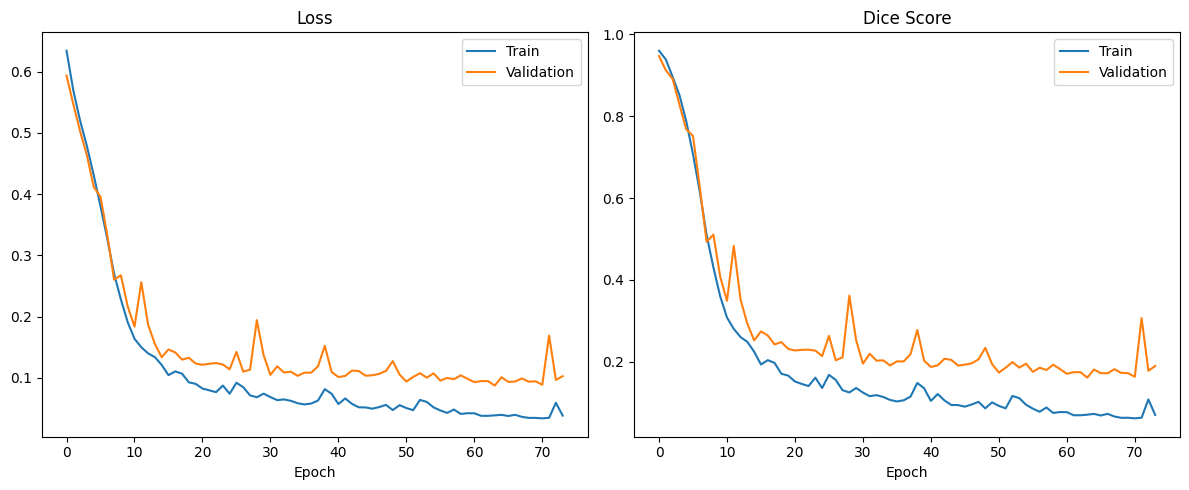

Evaluating: 100%|██████████| 589/589 [00:03<00:00, 154.18it/s]


Test Dice Score: 0.8898


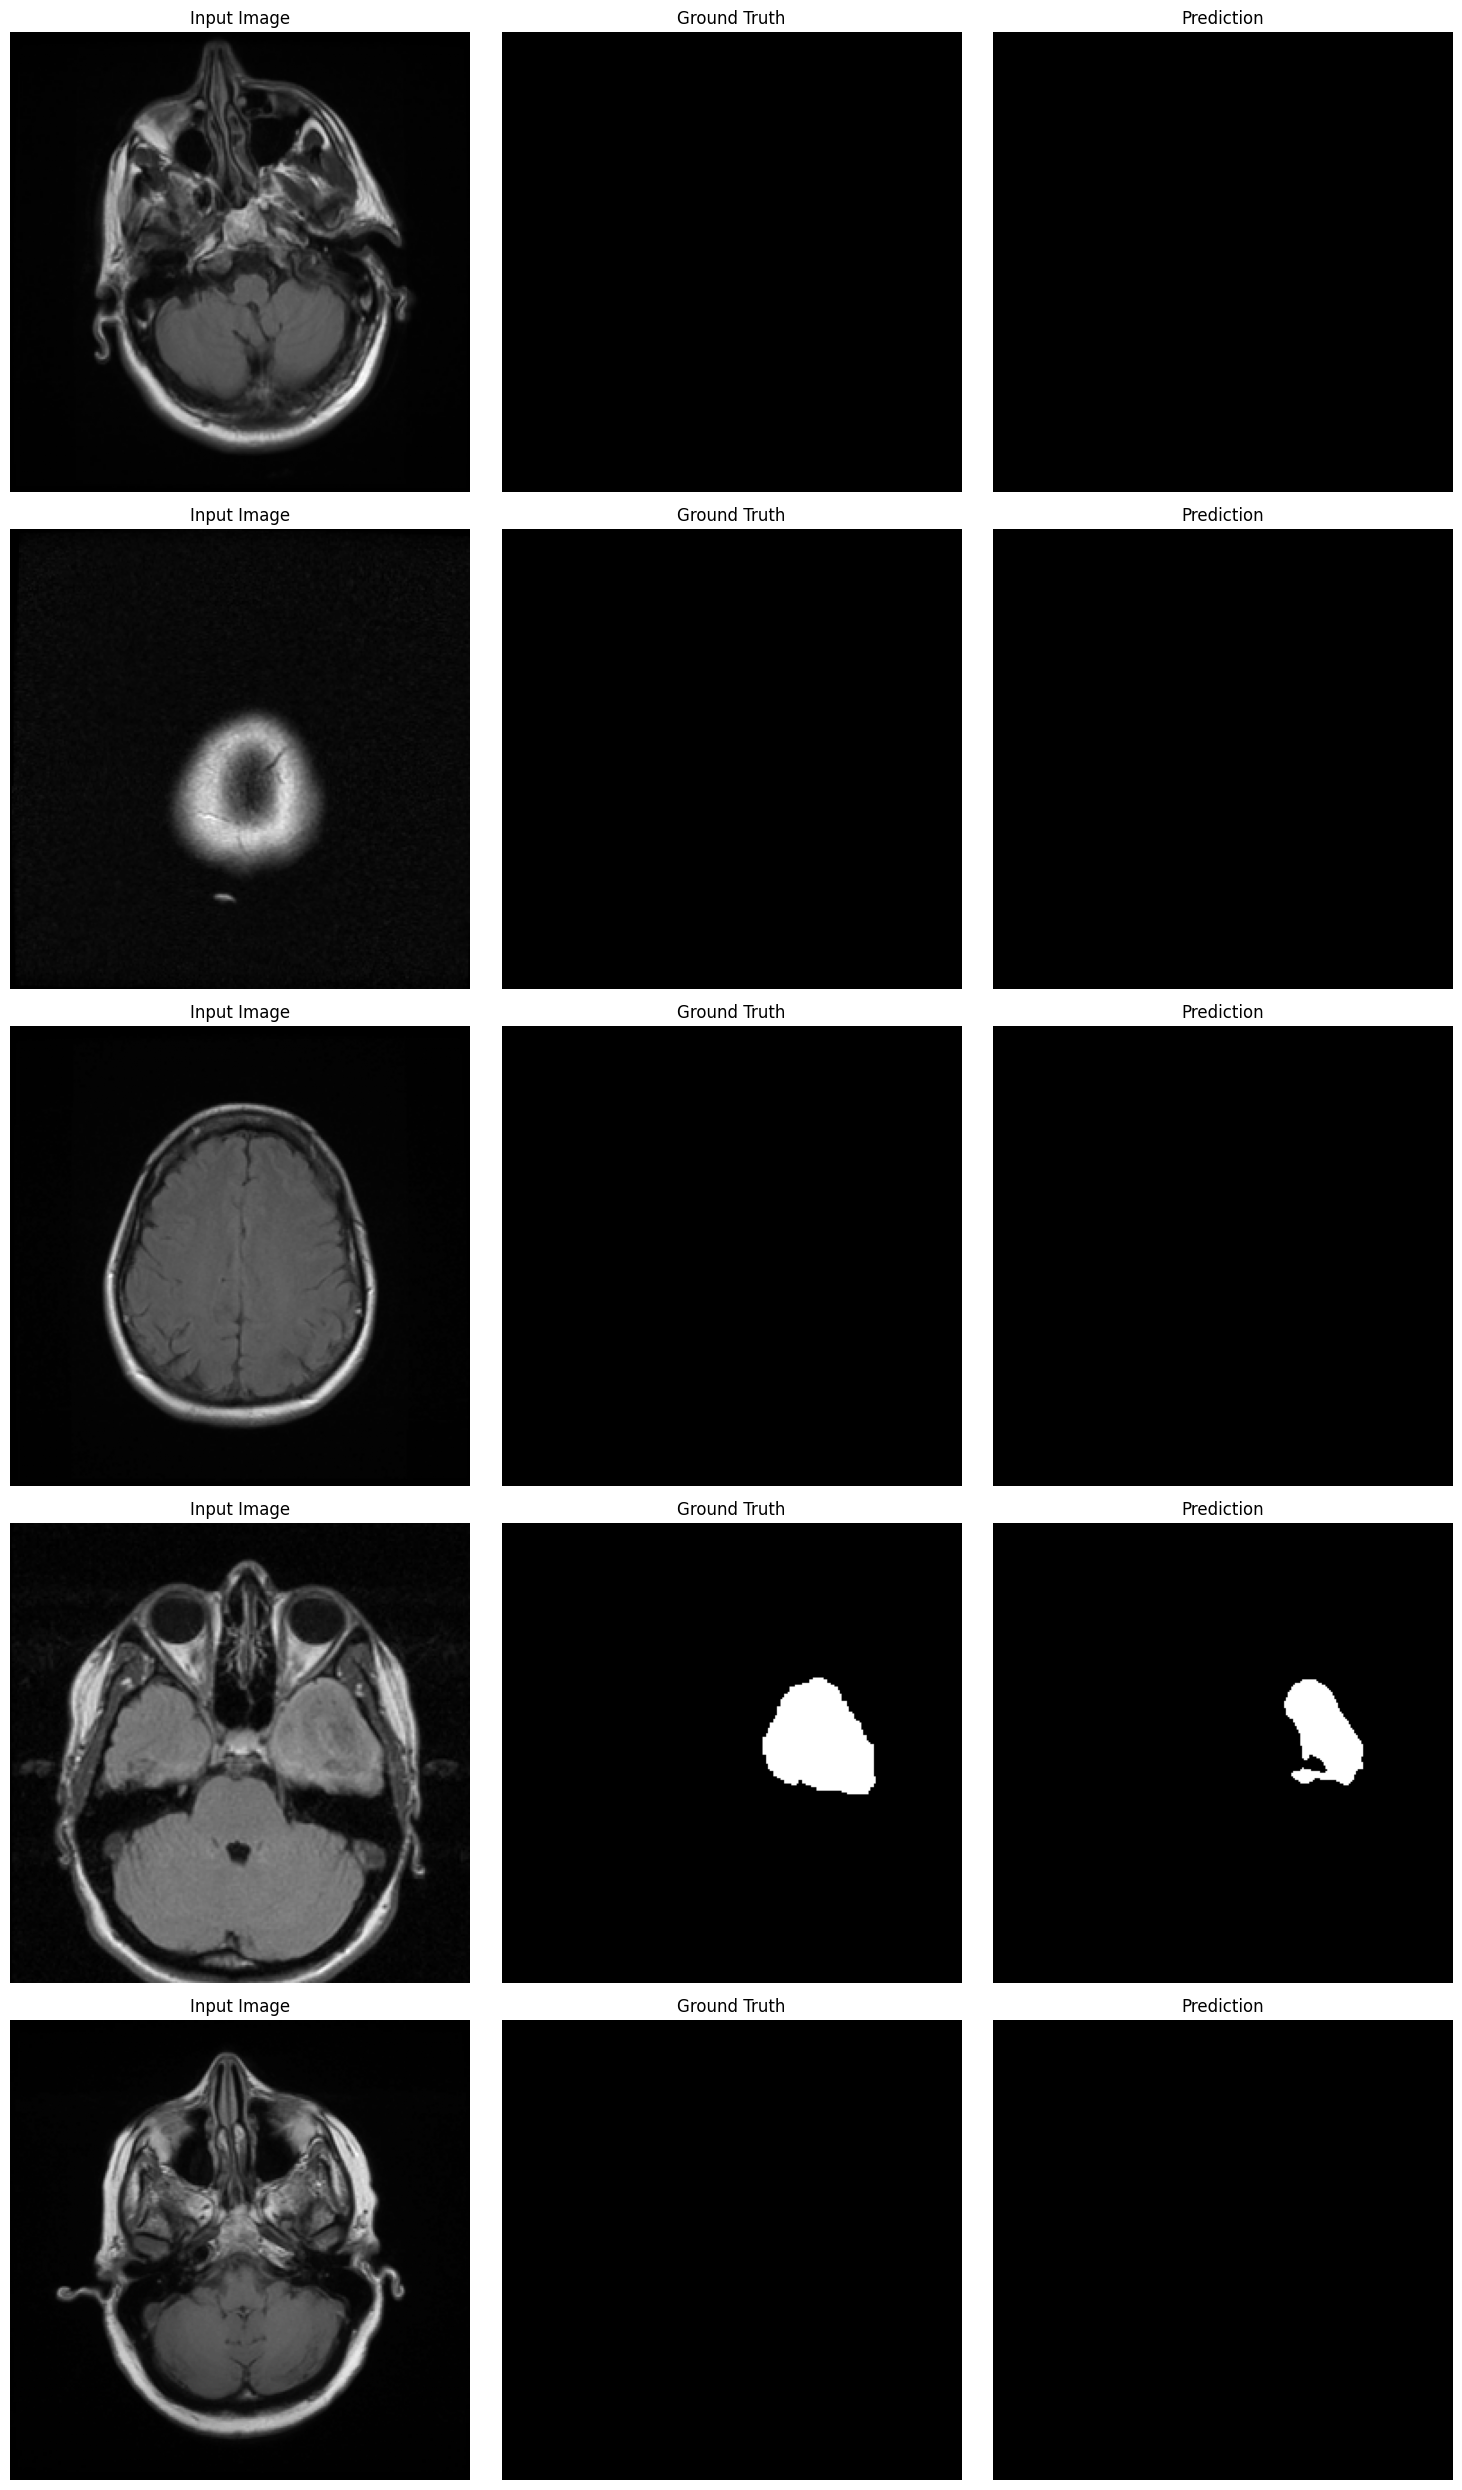

In [3]:
from segmentation import run_segmentation_pipeline

# # Define your custom U-Net or any segmentation model here
# class MyCustomUNet(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super(MyCustomUNet, self).__init__()
#         # Define your custom architecture here
#         # ...

#     def forward(self, x):
#         # Define the forward pass
#         # ...
#         return output

# Create your model instance
my_model = ResUNet(in_channels=1, out_channels=1)

# Run the pipeline with custom model and naming
trained_model, dice_score = run_segmentation_pipeline(
    model=my_model,
    base_dir="kaggle_3m",
    model_name="test_resunet",
    batch_size=8,
    patience=10
)